# Neural Radiance Fields (NeRF)

*Please note that this is an optional notebook meant to introduce more advanced concepts. If you’re up for a challenge, take a look and don’t worry if you can’t follow everything. There is no code to implement—only some cool code for you to learn and run!*

### Goals

In this notebook, you'll learn how to use Neural Radiance Fields to generate new views of a complex 3D scene using only a couple input views, first proposed by [NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis](https://arxiv.org/abs/2003.08934) (Mildenhall et al. 2020). Though 2D GANs have seen success in high-resolution image synthesis, NeRF has quickly become a popular technique to enable high-resolution 3D-aware GANs.

![Water fountain](https://raw.githubusercontent.com/alexxke/nerf-images/main/colorspout_200k_rgb.gif)
![Water fountain](https://raw.githubusercontent.com/alexxke/nerf-images/main/orchid.gif)
![Synthetic Lego Dataset](https://raw.githubusercontent.com/alexxke/nerf-images/main/lego.gif)

Image Credit: [Matthew Tancik](https://www.matthewtancik.com/nerf)

## Overview

NeRF is an approach for **novel view synthesis**, where given some input images of a scene and cooresponding camera poses, we want to generate new images of the same scene from arbitrary camera poses. Because training a full NeRF can take hours to days, we will study a feature-limited tiny NeRF ([Official GitHub](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb)) to train faster, while highlighting the major differences.

### How does NeRF work?

NeRF represents a scene as a function mapping position and direction to color and volumetric density (how opaque is this object?), $F_\Theta : (x, y, z, \theta, \phi) \mapsto (R, G, B, \sigma)$. The authors then use these colors and densities with classic volume rendering techniques to compose these values into an image.

NeRF represents this mapping with a simple Multilayer Perceptron (MLP), which is differentiable and thus allows for explicit optimization by comparing the synthesized with the ground truth images.

![NeRF Pipeline](https://github.com/bmild/nerf/blob/master/imgs/pipeline.jpg?raw=true)
Image credit: [Official GitHub](https://github.com/bmild/nerf)

## Getting Started

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def batch_generator(inputs, batch_size):
    """
    Generates batches of `batch_size` from `inputs` array.
    """
    l = inputs.shape[0]
    for i in range(0, l, batch_size):
        yield inputs[i:min(i + batch_size, l)]

Let's load our data from the official NeRF GitHub and plot a holdout image

--2024-08-12 07:46:30--  https://bmild.github.io/nerf/tiny_nerf_data.npz
Resolving bmild.github.io (bmild.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to bmild.github.io (bmild.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M) [application/octet-stream]
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  --.-KB/s    in 0.09s   

2024-08-12 07:46:31 (134 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


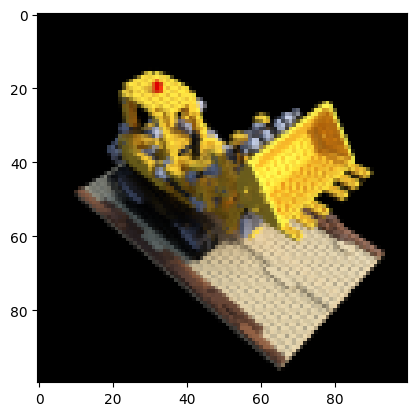

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://bmild.github.io/nerf/tiny_nerf_data.npz

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
# use the first 100 images for training
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

images = torch.from_numpy(images).to(device)
poses = torch.from_numpy(poses).to(device)
testimg = torch.from_numpy(testimg).to(device)
testpose = torch.from_numpy(testpose).to(device)

We define a function to compute the rays passing through an image from a given position.

In [3]:
def get_rays(height, width, focal_length, cam2world):
    """
    Compute the rays (origins and directions) passing through an image with
    `height` and `width` (in pixels). `focal_length` (in pixels) is a property
    of the camera. `cam2world` represents and transform tensor from a 3D point
    in the "camera" frame of reference to the "world" frame of reference (the
    `pose` in our dataset).
    """
    i, j = torch.meshgrid(
        torch.arange(width).to(cam2world),
        torch.arange(height).to(cam2world),
        indexing="xy"
    )
    dirs = torch.stack([
        (i.cpu() - width / 2) / focal_length,
        - (j.cpu() - height / 2) / focal_length,
        - torch.ones_like(i.cpu())
    ], dim=-1).to(cam2world)
    rays_d = torch.sum(dirs[..., None, :] * cam2world[:3, :3], dim=-1)
    rays_o = cam2world[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d

## Building NeRF


### Positional Encoding

To better model high-frequency functions, the authors use an encoding function defined

$$\gamma(p) = (\sin(2^0 \pi p), \cos(2^0 \pi p), \dots, \sin(2^{L-1} \pi p), \cos(2^{L-1} \pi p)).$$

In the NeRF architecture, $\gamma$ is applied to each of the 5 input dimensions $(x, y, z, \theta, \phi)$.

In [4]:
def positional_encoding(x, L_embed=6):
    """
    Returns tensor representing positional encoding $\gamma(x)$ of `x` with
    `L_embed` corresponding to $L$ in the above.
    """
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2 ** i * x))
    return torch.cat(rets, dim=-1)

### Architecture

NeRF is a simple MLP with ReLU activations, concatenations at specific layers, and outputs at different stages shown below:

<img src="https://miro.medium.com/max/1129/1*q3fLvJFfoUdtVhsXeeTNXw.png" alt="NeRF Architecture" width="800"/>

For training speed, we instead implement a smaller MLP in the same spirit:



In [5]:
class TinyNeRF(nn.Module):
    """
    Implements 4 layer MLP as a tiny example of the NeRF design
    """
    def __init__(self, hidden_dim=128, L_embed=6):
        super().__init__()
        in_dim = 3 + 3 * 2 * L_embed
        self.layer1 = nn.Linear(in_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim + in_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, 4)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        out = F.relu(self.layer3(torch.cat([out, x], dim=-1)))
        out = self.layer4(out)
        return out

### Volume Rendering

Consider a camera ray $\mathbf r(t) = \mathbf o + t \mathbf d$, with origin $\mathbf o$ and direction $\mathbf d$. If each 3D point along this ray is associated with a color $\mathbf c(\mathbf r(t), \mathbf d)$ and density $\sigma(\mathbf r(t)$, then the authors render the expected color at $\mathbf r(t)$ as

$$C(\mathbf r) = \int_{t_n}^{t_f} T(t) \sigma(\mathbf r(t)) \mathbf c(\mathbf r(t), \mathbf d) dt,$$

where

$$T(t) = \exp \left( - \int_{t_n}^t \sigma(\mathbf r(s)) ds \right),$$

and $t_n$ and $t_f$ are the near and far bounds of what we wish to render. We can interpret $T(t)$ as the probability that the ray travels from $t_n$ to $t$ without hitting any other particle.

This formulation is continuous, so the authors discretize it with stratified sampling: divide the interval $[t_n, t_f]$ into $N$ even bins, and then sample uniformly over each bin. The sampling is critical so we can roughly cover the whole interval over the course of training. This yields the discretization

$$\hat C(\mathbf r) = \sum_{i=1}^N T_i (1 - \exp(- \sigma_i \delta_i)) \mathbf c_i,$$

with

$$T_i = \exp \left( - \sum_{j=1}^{i-1} \sigma_j \delta_j \right),$$

and $\delta_i = t_{i+1} - t_i$ as the difference series between sample points.

In [6]:
def render_rays(
    model, rays_o, rays_d, near, far, N_samples, encoding_fn, rand=True
):
    """
    Use `model` to render the rays parameterized by `rays_o` and `rays_d`
    between `near` and `far` limits with `N_samples`.
    """
    # sample query pts
    z_vals = torch.linspace(near, far, N_samples).to(rays_o)
    if rand:
        z_vals = (
            torch.rand(list(rays_o.shape[:-1]) + [N_samples])
            * (far - near) / N_samples
        ).to(rays_o) + z_vals
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

    # run query pts through model to get radiance fields
    pts_flat = pts.reshape((-1, 3))
    encoded_pts_flat = encoding_fn(pts_flat)
    batches = batch_generator(encoded_pts_flat, batch_size=BATCH_SIZE)
    preds = []
    for batch in batches:
        preds.append(model(batch))
    radiance_fields_flat = torch.cat(preds, dim=0)
    radiance_fields = torch.reshape(
        radiance_fields_flat, list(pts.shape[:-1]) + [4]
    )

    # compute densities and colors
    sigma_a = F.relu(radiance_fields[..., 3])
    rgb = torch.sigmoid(radiance_fields[..., :3])

    # do volume rendering
    oneE10 = torch.tensor([1e10], dtype=rays_o.dtype, device=rays_o.device)
    dists = torch.cat([
        z_vals[..., 1:] - z_vals[..., :-1],
        oneE10.expand(z_vals[..., :1].shape)
    ], dim=-1)
    alpha = 1 - torch.exp(-sigma_a * dists)
    weights = torch.roll(torch.cumprod(1 - alpha + 1e-10, dim=-1), 1, dims=-1)
    weights[..., 0] = 1
    weights = alpha * weights

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * z_vals).sum(dim=-1)
    acc_map = weights.sum(dim=-1)
    return rgb_map, depth_map, acc_map

### Loss Function and Optimizer

The authors formulate a simple loss function as the total squared error between the rendered and ground truth RGB image values. The authors use the Adam optimizer with default parameters and learning rate that begins at $5 \times 10^{-4}$ and exponentially decays to $5 \times 10^{-5}$.

### Modifications

* **Input dimension**: Unlike the 5D input of the original NeRF model, our TinyNeRF only uses 3 input dimensions $(x, y, z)$, omitting the camera angle.
* **Architecture**: We simplified the NeRF architecture to train faster.
* **Optimizer**: We use the default Adam optimizer (lr= $5 \times 10^{-3}$) without exponential decay.
* **Hierarchical Volume Sampling**: Because sampling uniformly across a camera ray is not efficient (since much of the ray does not intersect with the object) NeRF actually uses a coarse network to determine where to sample, and then a fine network that samples from points that will contribute most to the output image. We use the simpler stratified sampling.


## Training NeRF

Finally we train NeRF! The training cell below should take around five minutes to run (with GPU runtime).

Loss: 4723.73193359375


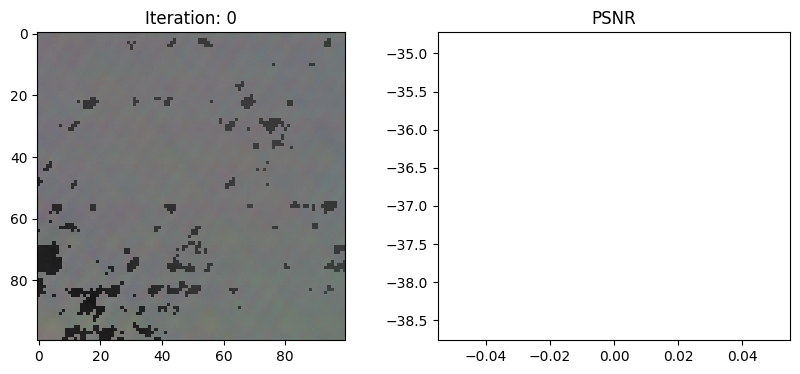

Loss: 810.0394287109375


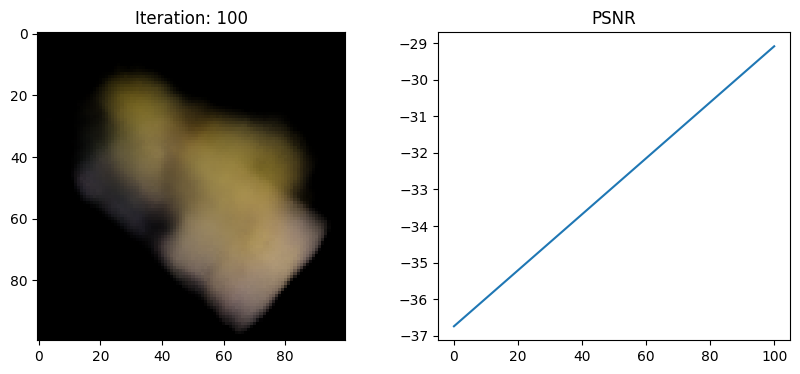

Loss: 350.45062255859375


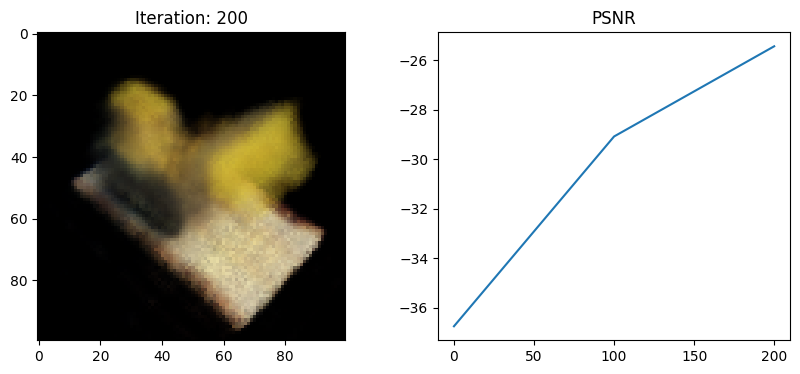

Loss: 266.5643615722656


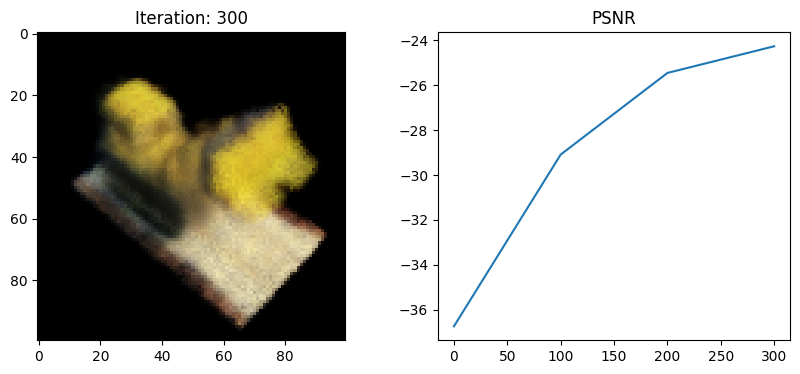

Loss: 236.9390869140625


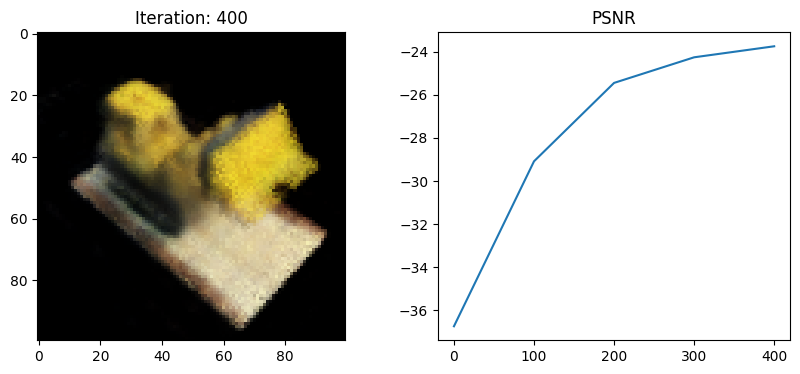

Loss: 255.3772735595703


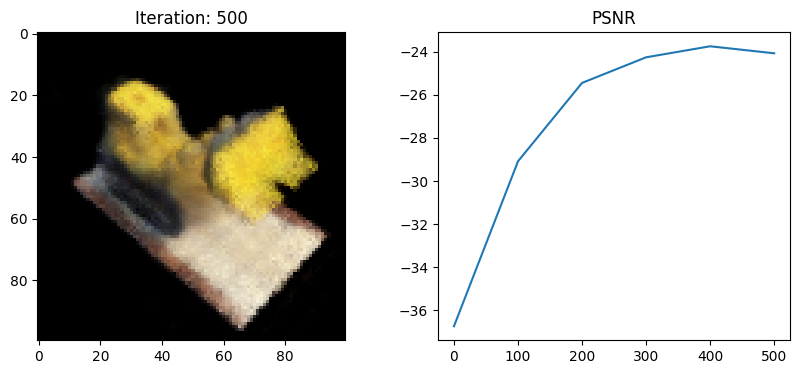

Loss: 234.12677001953125


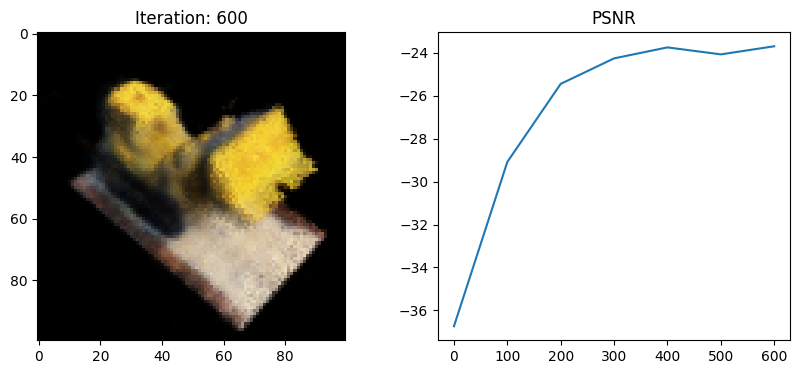

Loss: 209.0592041015625


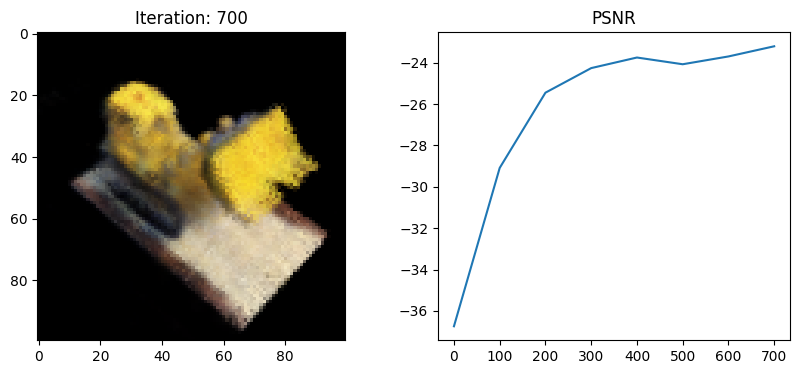

Loss: 205.49636840820312


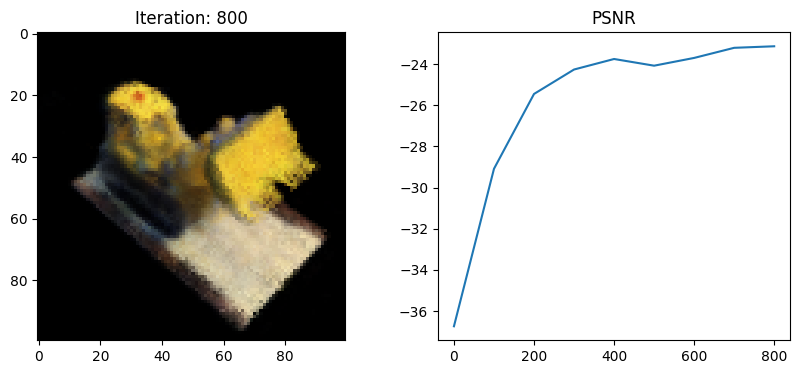

Loss: 197.933837890625


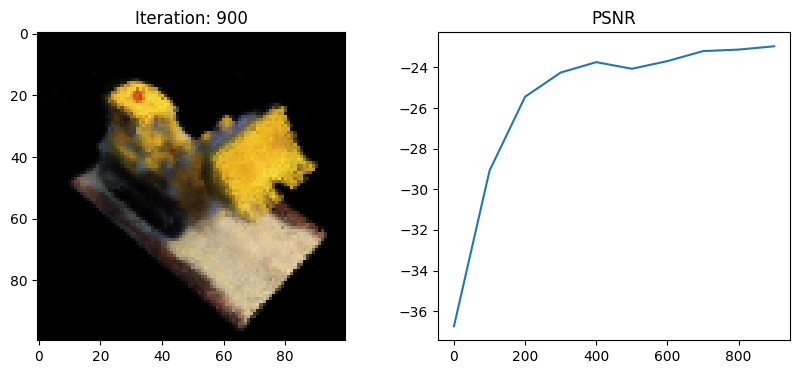

Loss: 166.09439086914062


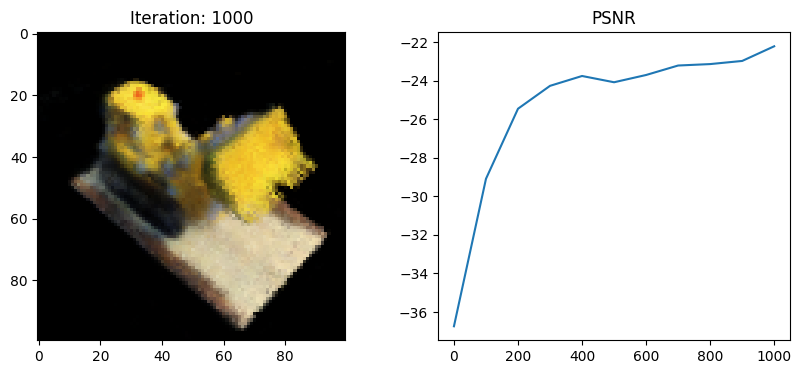

Done


In [7]:
# define parameters
NUM_ENCODING_FUNCTIONS = 6
NEAR = 2
FAR = 6
DEPTH_SAMPLES = 64
LEARNING_RATE = 5e-3
BATCH_SIZE = 16384
NUM_EPOCHS = 1000
DISPLAY_EVERY = 100
HEIGHT, WIDTH = images.shape[1:3]
FOCAL = data['focal']
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# initialize encoding function, model, loss, and optimizer
encoding_fn = lambda x: positional_encoding(x, L_embed=NUM_ENCODING_FUNCTIONS)
model = TinyNeRF(L_embed=NUM_ENCODING_FUNCTIONS)
model.to(device)
loss_fn = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# for plotting the loss and iteration during training
psnrs = []
iternums = []

for i in range(NUM_EPOCHS + 1):
    # sample an image from our training set
    img_idx = np.random.randint(images.shape[0])
    target = images[img_idx].to(device)
    pose = poses[img_idx].to(device)

    # get the rays passing through the image and forward pass the model
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, FOCAL, pose)
    rgb, _, _ = render_rays(
        model, rays_o, rays_d, near=NEAR, far=FAR, N_samples=DEPTH_SAMPLES,
        encoding_fn=encoding_fn
    )

    # backward pass
    loss = loss_fn(rgb, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # plot the model's render of the test image and loss at each iteration
    if i % DISPLAY_EVERY == 0:
        rays_o, rays_d = get_rays(HEIGHT, WIDTH, FOCAL, testpose)
        rgb, _, _ = render_rays(
            model, rays_o, rays_d, near=NEAR, far=FAR, N_samples=DEPTH_SAMPLES,
            encoding_fn=encoding_fn
        )
        loss = loss_fn(rgb, testimg)
        print(f"Loss: {loss.item()}")
        psnr = -10 * torch.log10(loss)
        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb.detach().cpu().numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

### Render 3D Video

Looks great! Let's make a video of our result.

In [8]:
# define some transformation tensors for translations and rotations about
# different axes
trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)


def pose_spherical(theta, phi, radius):
    """
    Compute a transformation tensor for a spherical coordinates
    (`theta`, `phi`, `radius`)
    """
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w.numpy()
    return c2w

In [9]:
# run poses that encircle the object through our trained model and make a video
frames = []
for th in np.linspace(0., 360., 120, endpoint=False):
    c2w = pose_spherical(th, -30, 4)
    c2w = torch.from_numpy(c2w).to(device).float()
    rays_o, rays_d = get_rays(HEIGHT, WIDTH, FOCAL, c2w[:3,:4])
    rgb, _, _ = render_rays(
        model, rays_o, rays_d, NEAR, FAR, N_samples=DEPTH_SAMPLES,
        encoding_fn=encoding_fn
    )
    frames.append((255*np.clip(rgb.cpu().detach().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [10]:
# embed the video in the notebook
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Extensions

Tying this back to GANs, many papers have found success in applying NeRFs to 3D aware GANs. This is a very active research area, so here's a couple pointers:

* [GRAF: Generative Radiance Fields for 3D-Aware Image Synthesis](https://arxiv.org/abs/2007.02442) (Schwarz et al. 2020) demonstrated a NeRF model that can generate classes of objects by conditioning on shape and appearance.

* [pi-GAN: Periodic Implicit Generative Adversarial Networks for 3D-Aware Image Synthesis](https://arxiv.org/abs/2012.00926) (Chan et al. 2021) proposed the current, as of writing, state-of-the-art 3D aware image synthesis technique through more expressive architectures. A comparison of these techniques is below, credit [Marco Monteiro](https://marcoamonteiro.github.io/pi-GAN-website/).

    ![Comparison of 3D-aware GANs](https://raw.githubusercontent.com/alexxke/nerf-images/main/comparison.gif)

* [GIRAFFE: Representing Scenes as Compositional Generative Neural Feature Fields](https://arxiv.org/abs/2011.12100) (Niemeyer and Geiger 2021) developed an approach that can model multi-object scenes as compositions of NeRFs. Check out some visualizations of object translation from a 2D GAN (left) and GIRAFFE (right), credit to [Michael Niemeyer](https://m-niemeyer.github.io/project-pages/giraffe/index.html).

    ![2D GAN single object translation](https://raw.githubusercontent.com/alexxke/nerf-images/main/2dgan.gif)
![GIRAFFE single object translation](https://raw.githubusercontent.com/alexxke/nerf-images/main/giraffe.gif)

* [Block-NeRF: Scalable Large Scene Neural View Synthesis](https://arxiv.org/abs/2202.05263) (Tancik et al. 2022) takes scene decomposition even further by introducing tweaks that allow Block-NeRF to render an entire neighborhood of San Francisco (credit to [Waymo Research](https://waymo.com/research/block-nerf/)).

    ![Block-NeRF on Grace Cathedral](https://raw.githubusercontent.com/alexxke/nerf-images/main/grace_cathedral.gif)


For more general improvements on this technique, Frank Dellaert put together a great [anthology](https://dellaert.github.io/NeRF/).